In [ ]:
from google.colab import files


# Upload the zip file
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import os

# Path to your uploaded zip file
zip_path = "/content/archive (1).zip"

# Folder where you want to extract
extract_dir = "my_dataset_folder"

# Create folder if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted '{zip_path}' into folder '{extract_dir}'")

# List files inside extracted folder
print("Files inside extracted folder:")
print(os.listdir(extract_dir))

Extracted '/content/archive (1).zip' into folder 'my_dataset_folder'
Files inside extracted folder:
['Potato']


In [ ]:
# Import standard Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#file path
train_dir = "/content/my_dataset_folder/Potato/Test"
test_dir = "/content/my_dataset_folder/Potato/Train"
valid_dir = "/content/my_dataset_folder/Potato/Valid"

In [ ]:
# Data Rescaling and augmentation

In [ ]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
], name="data_augmentation")


In [ ]:
import tensorflow as tf

# Set image size and batch size
IMG_SIZE = (224, 224)   # resize all images to 224x224
BATCH_SIZE = 32         # number of images per batch

# -------------------------------
# Training dataset
# -------------------------------
train_data = (
    tf.keras.preprocessing.image_dataset_from_directory(
        directory=train_dir,             # training folder path
        image_size=IMG_SIZE,             # resize images
        label_mode='categorical',        # labels as one-hot encoded vectors
        batch_size=BATCH_SIZE,           # process in mini-batches
        shuffle=True                     # shuffle dataset order
    )
    .cache()                             # keep data in memory after first read (faster)
    .shuffle(1000)                       # shuffle the dataset with buffer size 1000
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch batches in background
)

# -------------------------------
# Test dataset
# -------------------------------
test_data = (
    tf.keras.preprocessing.image_dataset_from_directory(
        directory=test_dir,              # testing folder path
        image_size=IMG_SIZE,
        label_mode='categorical',
        batch_size=BATCH_SIZE
    )
    .cache()                             # cache test data (small dataset, loads faster)
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch for better pipeline performance
)

# -------------------------------
# Validation dataset (raw first)
# -------------------------------
valid_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_dir,             # validation folder path
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

# Get class names from validation dataset (same classes as train/test)
class_names = valid_datasets.class_names

# Optimize validation dataset
valid_data = (
    valid_datasets
    .cache()                         # cache in memory for speed
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch for training efficiency
)




Found 300 files belonging to 3 classes.
Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [12]:
images, labels = next(iter(train_data))
total_classes = labels.shape[-1]
print("Total classes:", total_classes)


Total classes: 3


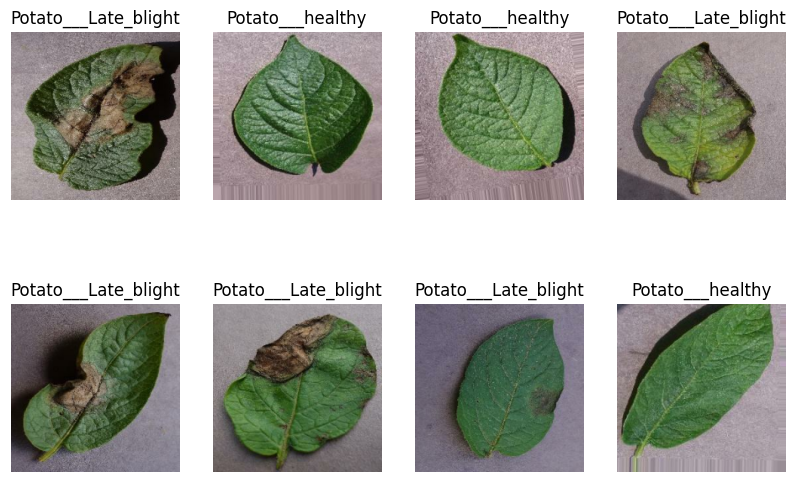

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))

# Take one batch of (images, labels)
for image_batch, label_batch in train_data.take(1):
    for i in range(8):   # show first 8 images
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))   # convert to displayable image
        plt.title(class_names[np.argmax(label_batch[i])])    # show class name
        plt.axis("off")

plt.show()


In [16]:
# Create Checkpoint

checkpoint_path = "CheckPoint/cp.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)



In [17]:
# Create model

In [18]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(total_classes, activation='softmax', name='output_layers')

])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 60) │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, None, None, 60) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 60) │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, None, 60) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 60) │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, None, 60) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 60)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layers (Dense)           │ (None, 3)              │           183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,783 (260.87 KB)

 Trainable params: 66,783 (260.87 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile model

In [22]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [23]:
#Fit the mode
history = model.fit(
    train_data,
    epochs=200,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.3574 - loss: 1.1038
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to CheckPoint/cp.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3561 - loss: 1.1033 - val_accuracy: 0.3333 - val_loss: 1.0879
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.3425 - loss: 1.0787
Epoch 2: val_accuracy improved from 0.33333 to 0.46556, saving model to CheckPoint/cp.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3435 - loss: 1.0788 - val_accuracy: 0.4656 - val_loss: 1.0675
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.4255 - loss: 1.0638
Epoch 3: val_accuracy improved from 0.46556 to 0.56556, saving model to CheckPoint/cp.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 967ms/step - accuracy: 0.4262 - loss: 1.0622 - val_accuracy: 0.5656 - val_loss: 1.0199
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.4976 - loss: 1.0046
Epoch 4: val_accu

In [24]:
def bestWeightModelEvaluate(model, weight_path, data):
  cp_model = tf.keras.models.clone_model(model)
  cp_model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )
  cp_model.load_weights(weight_path)
  cp_model.evaluate(data)

In [25]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = valid_data
)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9547 - loss: 0.1074


In [26]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = test_data
)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9600 - loss: 0.1385


In [27]:
model.save("CheckPoint/final_model.keras")


In [31]:

loaded_model = tf.keras.models.load_model("/content/CheckPoint/final_model.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


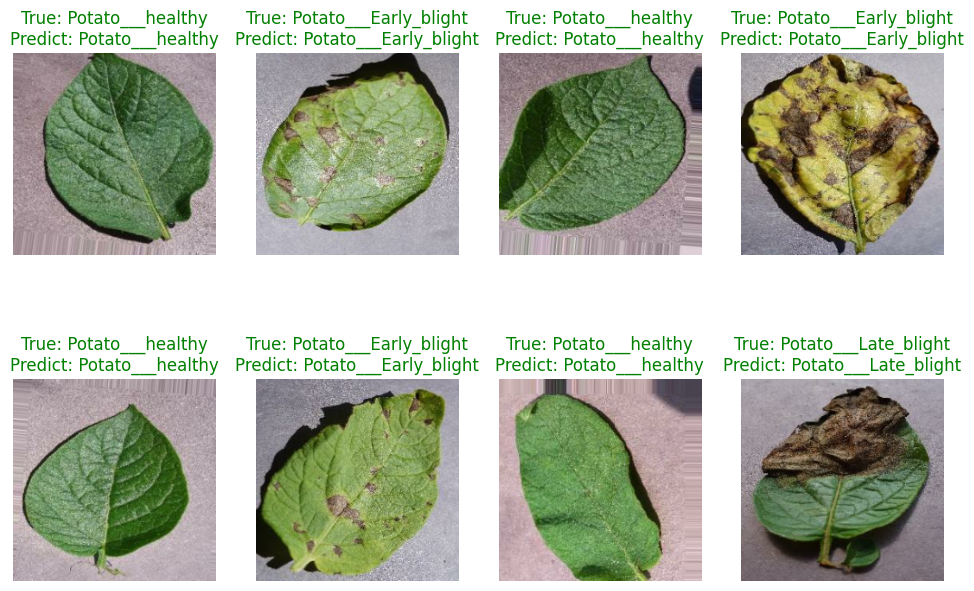

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from test_data
for image_batch, label_batch in test_data.take(1):
    # Predict the batch
    predictions = loaded_model.predict(image_batch)
    predicted_classes = np.argmax(predictions, axis=-1)

    # Visualize first 8 images
    plt.figure(figsize=(12,12))
    for i in range(8):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predicted_classes[i]]
        title = f"True: {true_class}\nPredict: {predict_class}"

        plt.title(title, color='g' if true_class == predict_class else 'r')
        plt.axis("off")
    plt.show()


In [33]:
!zip -r /content/CheckPoint.zip /content/CheckPoint


  adding: content/CheckPoint/ (stored 0%)
  adding: content/CheckPoint/cp.weights.h5 (deflated 13%)
  adding: content/CheckPoint/final_model.keras (deflated 14%)


In [34]:
from google.colab import files
files.download("/content/CheckPoint.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
!zip -r /content/my_project.zip /content/CheckPoint /content/my_dataset_folder


  adding: content/CheckPoint/ (stored 0%)
  adding: content/CheckPoint/cp.weights.h5 (deflated 13%)
  adding: content/CheckPoint/final_model.keras (deflated 14%)
  adding: content/my_dataset_folder/ (stored 0%)
  adding: content/my_dataset_folder/Potato/ (stored 0%)
  adding: content/my_dataset_folder/Potato/Train/ (stored 0%)
  adding: content/my_dataset_folder/Potato/Train/Potato___Early_blight/ (stored 0%)
  adding: content/my_dataset_folder/Potato/Train/Potato___Early_blight/c48693cf-14bb-48ec-96fe-240bd2269866___RS_Early.B 7609.JPG (deflated 1%)
  adding: content/my_dataset_folder/Potato/Train/Potato___Early_blight/dcc9e3a4-04dc-46fd-9bc9-739334aa23d9___RS_Early.B 6799.JPG (deflated 1%)
  adding: content/my_dataset_folder/Potato/Train/Potato___Early_blight/bddc2487-ecc6-447e-902f-3560a62e5e83___RS_Early.B 7307.JPG (deflated 1%)
  adding: content/my_dataset_folder/Potato/Train/Potato___Early_blight/f2e7be26-b7d3-4e99-8630-8b1650192b02___RS_Early.B 7275.JPG (deflated 1%)
  adding: c

In [36]:
from google.colab import files
files.download("/content/my_project.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>